<a href="https://colab.research.google.com/github/Abhisheklal2809/Machine-Learning-Project/blob/main/resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Install necessary packages
!pip install torch torchvision opencv-python numpy scikit-learn kagglehub

In [ ]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Kaggle dataset path (auto-downloaded)
import kagglehub
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
base_path = os.path.join(path, "Dataset", "Train")
real_images_dir = os.path.join(base_path, "Real")
fake_images_dir = os.path.join(base_path, "Fake")

100%|██████████| 1.68G/1.68G [00:34<00:00, 52.6MB/s]

Extracting files...


In [ ]:
# Function to load images
def load_images(directory, label, limit=None):
    """
    Load images and associate with a label.

    Args:
        directory (str): Path to the directory.
        label (int): 0 for Real, 1 for Fake.
        limit (int): Max number of images to load.

    Returns:
        list: A list of (image, label) tuples.
    """
    data = []
    file_list = os.listdir(directory)
    if limit:
        file_list = file_list[:limit]
    for file_name in file_list:
        img_path = os.path.join(directory, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append((img, label))
    return data


In [ ]:
# Load Real and Fake images
real_data = load_images(real_images_dir, 0, limit=20000)
fake_data = load_images(fake_images_dir, 1, limit=20000)

# Combine, shuffle, and split
dataset = real_data + fake_data
np.random.shuffle(dataset)
X = np.array([x[0] for x in dataset]) / 255.0  # Normalize pixel values to [0, 1]
y = np.array([x[1] for x in dataset])          # Labels (0 for Real, 1 for Fake)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
# Data augmentation and preprocessing for ResNet-50
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet's standard normalization
])

train_dataset = ImageDataset(X_train, y_train, transform)
test_dataset = ImageDataset(X_test, y_test, transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet's standard normalization
]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# Load ResNet-50 model with pre-trained weights
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match our number of classes (2: Real or Fake)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes (Real, Fake)

# Move the model to the device (GPU or CPU)
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.summary()

In [ ]:


from sklearn.metrics import accuracy_score
from tqdm import tqdm  # For progress bar

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    # Initialize tqdm progress bar for the current epoch
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch') as pbar:
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update loss
            total_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar with current loss
            pbar.set_postfix(loss=total_loss / len(all_preds), accuracy=accuracy_score(all_labels, all_preds))

    # Calculate the average loss and accuracy for the epoch
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%")


Epoch 1/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.792, loss=0.0142]


Epoch 1/20, Loss: 0.4540, Accuracy: 79.17%


Epoch 2/20: 100%|██████████| 150/150 [00:57<00:00,  2.59batch/s, accuracy=0.882, loss=0.00856]


Epoch 2/20, Loss: 0.2739, Accuracy: 88.23%


Epoch 3/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.905, loss=0.00722]


Epoch 3/20, Loss: 0.2311, Accuracy: 90.52%


Epoch 4/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.917, loss=0.00625]


Epoch 4/20, Loss: 0.1999, Accuracy: 91.69%


Epoch 5/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.929, loss=0.00568]


Epoch 5/20, Loss: 0.1819, Accuracy: 92.90%


Epoch 6/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.927, loss=0.00549]


Epoch 6/20, Loss: 0.1757, Accuracy: 92.69%


Epoch 7/20: 100%|██████████| 150/150 [00:57<00:00,  2.60batch/s, accuracy=0.927, loss=0.00557]


Epoch 7/20, Loss: 0.1784, Accuracy: 92.73%


Epoch 8/20: 100%|██████████| 150/150 [00:57<00:00,  2.60batch/s, accuracy=0.936, loss=0.00489]


Epoch 8/20, Loss: 0.1565, Accuracy: 93.65%


Epoch 9/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.939, loss=0.00462]


Epoch 9/20, Loss: 0.1477, Accuracy: 93.94%


Epoch 10/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.953, loss=0.00392]


Epoch 10/20, Loss: 0.1254, Accuracy: 95.31%


Epoch 11/20: 100%|██████████| 150/150 [00:59<00:00,  2.51batch/s, accuracy=0.946, loss=0.00393]


Epoch 11/20, Loss: 0.1258, Accuracy: 94.60%


Epoch 12/20: 100%|██████████| 150/150 [00:57<00:00,  2.59batch/s, accuracy=0.952, loss=0.00364]


Epoch 12/20, Loss: 0.1163, Accuracy: 95.21%


Epoch 13/20: 100%|██████████| 150/150 [00:58<00:00,  2.58batch/s, accuracy=0.957, loss=0.00366]


Epoch 13/20, Loss: 0.1172, Accuracy: 95.67%


Epoch 14/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.958, loss=0.0034]


Epoch 14/20, Loss: 0.1090, Accuracy: 95.77%


Epoch 15/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.954, loss=0.0034]


Epoch 15/20, Loss: 0.1088, Accuracy: 95.44%


Epoch 16/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.961, loss=0.00309]


Epoch 16/20, Loss: 0.0989, Accuracy: 96.12%


Epoch 17/20: 100%|██████████| 150/150 [00:57<00:00,  2.62batch/s, accuracy=0.962, loss=0.0031]


Epoch 17/20, Loss: 0.0992, Accuracy: 96.17%


Epoch 18/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.961, loss=0.00301]


Epoch 18/20, Loss: 0.0963, Accuracy: 96.10%


Epoch 19/20: 100%|██████████| 150/150 [00:57<00:00,  2.60batch/s, accuracy=0.965, loss=0.00291]


Epoch 19/20, Loss: 0.0932, Accuracy: 96.54%


Epoch 20/20: 100%|██████████| 150/150 [00:57<00:00,  2.61batch/s, accuracy=0.958, loss=0.00326]

Epoch 20/20, Loss: 0.1042, Accuracy: 95.79%


In [ ]:
# Evaluate the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, axis=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 95.25%


In [ ]:
# Save the model
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/deepfake_detector_resnet50.pth")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
# # Prediction function using ResNet-50
# def predict_image(image_path, model):
#     model.eval()
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (224, 224))  # Resize image to 224x224
#     img = img / 255.0  # Normalize
#     img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

#     # Normalize the image in the same way as the training data
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     img = transform(img)

#     with torch.no_grad():
#         output = model(img)
#         pred = torch.argmax(output, axis=1).item()
#         return "Real" if pred == 0 else "Fake"

# # Test prediction on a new image
# test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/fake_1000.jpg"  # Update this path to your test image
# prediction = predict_image(test_image_path, model)
# print(f"The image is {prediction}.")


# import cv2
# import numpy as np

# def predict_image(image_path, model):
#     # Check if file exists
#     if not os.path.exists(image_path):
#         raise FileNotFoundError(f"The file at {image_path} does not exist.")

#     # Read the image
#     img = cv2.imread(image_path)
#     if img is None:
#         raise ValueError(f"Failed to load image at {image_path}. Please check the file format and path.")

#     # Verify the image shape
#     print(f"Original Image Shape: {img.shape}")

#     # Resize image to 224x224
#     img = cv2.resize(img, (224, 224))

#     # Normalize pixel values
#     img = img / 255.0

#     # Ensure the image has 3 dimensions (Height, Width, Channels)
#     if img.ndim == 2:  # If grayscale, add a channel dimension
#         img = np.expand_dims(img, axis=-1)

#     # Convert to tensor-like format for the model
#     img = np.expand_dims(img, axis=0)  # Add batch dimension
#     print(f"Processed Image Shape for Model: {img.shape}")

#     # Predict using the model
#     predictions = model.predict(img)
#     predicted_class = np.argmax(predictions, axis=1)

#     return predicted_class, predictions

# # Example usage
# test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/fake_1000.jpg"
# try:
#     predicted_label, prediction_probs = predict_image(test_image_path, model)
#     print(f"Predicted Class: {predicted_label}")
#     print(f"Prediction Probabilities: {prediction_probs}")
# except Exception as e:
#     print(f"Error: {e}")


import cv2
import numpy as np
import torch

def predict_image(image_path, model, device='cuda'):
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file at {image_path} does not exist.")

    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file format and path.")

    # Resize the image to the required input size
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values to range [0, 1]
    img = img / 255.0

    # Convert image to tensor format (C, H, W)
    img = np.transpose(img, (2, 0, 1))  # Change from HWC to CHW
    img = torch.tensor(img, dtype=torch.float32)  # Convert to float32 tensor

    # Add batch dimension and move to the specified device (GPU or CPU)
    img = img.unsqueeze(0).to(device)

    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        predictions = model(img)  # Forward pass

    # Get the predicted class (index of the max logit)
    predicted_class = torch.argmax(predictions, dim=1).item()

    return predicted_class, predictions

# Example usage
test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Real/real_100.jpg"

# Assuming `model` is your ResNet model
try:
    predicted_label, prediction_probs = predict_image(test_image_path, model, device='cuda')
    print(f"Predicted Class: {predicted_label}")
    print(f"Prediction Probabilities: {prediction_probs}")
except Exception as e:
    print(f"Error: {e}")



Predicted Class: 0
Prediction Probabilities: tensor([[ 0.2589, -0.3130]], device='cuda:0')


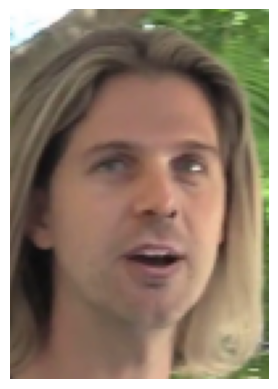

Predicted Class: 1
Prediction Probabilities: tensor([[-2.6413,  2.5687]], device='cuda:0')


In [ ]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt  # Import Matplotlib to display the image

def predict_image(image_path, model, device='cuda'):
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file at {image_path} does not exist.")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file format and path.")

    # Display the input image using Matplotlib
    # Convert from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

    # Resize the image to the required input size
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values using ImageNet stats
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert from numpy to PIL
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet means and stds
    ])
    img = transform(img)  # Apply the transform

    # Add batch dimension and move to the specified device (GPU or CPU)
    img = img.unsqueeze(0).to(device)

    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        predictions = model(img)  # Forward pass

    # Get the predicted class (index of the max logit)
    predicted_class = torch.argmax(predictions, dim=1).item()

    return predicted_class, predictions

# Example usage
test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/aagfhgtpmv-009-00.png"

# Assuming `model` is your ResNet model
try:
    predicted_label, prediction_probs = predict_image(test_image_path, model, device='cuda')
    print(f"Predicted Class: {predicted_label}")
    print(f"Prediction Probabilities: {prediction_probs}")
except Exception as e:
    print(f"Error: {e}")


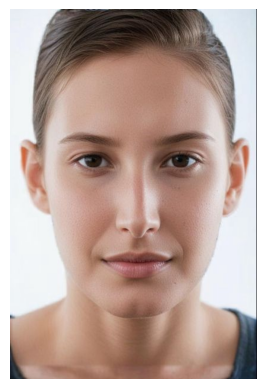

Predicted Class: 1
Prediction Probabilities: tensor([[-6.9576,  6.7162]], device='cuda:0')


In [ ]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt  # Import Matplotlib to display the image

def predict_image(image_path, model, device='cuda'):
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file at {image_path} does not exist.")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file format and path.")

    # Display the input image using Matplotlib
    # Convert from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

    # Resize the image to the required input size
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values using ImageNet stats
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert from numpy to PIL
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet means and stds
    ])
    img = transform(img)  # Apply the transform

    # Add batch dimension and move to the specified device (GPU or CPU)
    img = img.unsqueeze(0).to(device)

    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        predictions = model(img)  # Forward pass

    # Get the predicted class (index of the max logit)
    predicted_class = torch.argmax(predictions, dim=1).item()

    return predicted_class, predictions

# Example usage
test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/71acd29b06654c6dbe29d33f71826732.jpg"

# Assuming `model` is your ResNet model
try:
    predicted_label, prediction_probs = predict_image(test_image_path, model, device='cuda')
    print(f"Predicted Class: {predicted_label}")
    print(f"Prediction Probabilities: {prediction_probs}")
except Exception as e:
    print(f"Error: {e}")


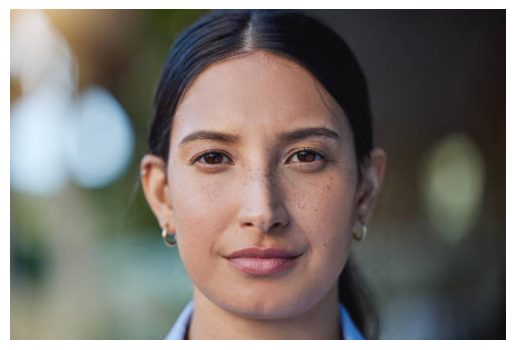

Predicted Class: 0
Prediction Probabilities: tensor([[ 1.4362, -1.5432]], device='cuda:0')


In [ ]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt  # Import Matplotlib to display the image

def predict_image(image_path, model, device='cuda'):
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file at {image_path} does not exist.")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the file format and path.")

    # Display the input image using Matplotlib
    # Convert from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

    # Resize the image to the required input size
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values using ImageNet stats
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert from numpy to PIL
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet means and stds
    ])
    img = transform(img)  # Apply the transform

    # Add batch dimension and move to the specified device (GPU or CPU)
    img = img.unsqueeze(0).to(device)

    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        predictions = model(img)  # Forward pass

    # Get the predicted class (index of the max logit)
    predicted_class = torch.argmax(predictions, dim=1).item()

    return predicted_class, predictions

# Example usage
test_image_path = "/root/.cache/kagglehub/datasets/manjilkarki/deepfake-and-real-images/versions/1/Dataset/Test/Fake/dp2.jpg"

# Assuming `model` is your ResNet model
try:
    predicted_label, prediction_probs = predict_image(test_image_path, model, device='cuda')
    print(f"Predicted Class: {predicted_label}")
    print(f"Prediction Probabilities: {prediction_probs}")
except Exception as e:
    print(f"Error: {e}")


In [ ]:

from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'y_true' and 'y_pred' are defined earlier in the notebook
# Replace these with actual labels if not already defined
# y_true = [...]  # Actual labels
# y_pred = [...]  # Predicted labels

# Calculate precision, recall, and f1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
classes = range(len(precision))

# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(classes))

plt.bar(x, precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color='lightgreen')
plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label='F1 Score', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score by Class')
plt.xticks(x + bar_width, classes)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'y_true' is not defined